In [1]:
from siphon.catalog import TDSCatalog
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p25deg/Best')
## dataset de interesse:
best_ds = list(best_gfs.datasets.values())[0]

In [2]:
ncss = best_ds.subset()
query = ncss.query()

In [3]:
from datetime import datetime, timedelta
dtime = datetime.utcnow() + timedelta(hours=48)
query.lonlat_box(north=5, south=-50, east=340, west=240).time(dtime)
query.accept('netcdf4')
query.variables('Temperature_surface',
                 'Geopotential_height_isobaric',
                   'Pressure_reduced_to_MSL_msl') # ou todas 'all'

var=Temperature_surface&var=Geopotential_height_isobaric&var=Pressure_reduced_to_MSL_msl&time=2020-05-08T21%3A53%3A04.726415&west=240&east=340&south=-50&north=5&accept=netcdf4

In [4]:
import metpy
from xarray.backends import NetCDF4DataStore
import xarray as xr


data = ncss.get_data(query)
data = xr.open_dataset(NetCDF4DataStore(data))
data_parse = data.metpy.parse_cf()

In [13]:
temperature_sfc = data_parse.Temperature_surface
pressure_sfc = data_parse.Pressure_reduced_to_MSL_msl
print( temperature_sfc )

<xarray.DataArray 'Temperature_surface' (time: 1, lat: 221, lon: 401)>
array([[[301.59442, 301.59442, ..., 301.79443, 301.79443],
        [301.59442, 301.49445, ..., 302.09442, 301.99445],
        ...,
        [279.89444, 279.79443, ..., 277.79443, 277.69443],
        [279.69443, 279.69443, ..., 277.59442, 277.59442]]], dtype=float32)
Coordinates:
    reftime  (time) datetime64[ns] 2020-05-06T12:00:00
  * time     (time) datetime64[ns] 2020-05-08T21:00:00
  * lat      (lat) float32 5.0 4.75 4.5 4.25 4.0 ... -49.25 -49.5 -49.75 -50.0
  * lon      (lon) float32 240.0 240.25 240.5 240.75 ... 339.5 339.75 340.0
    crs      object Projection: latitude_longitude
Attributes:
    long_name:                      Temperature @ Ground or water surface
    units:                          K
    abbreviation:                   TMP
    grid_mapping:                   LatLon_Projection
    Grib_Variable_Id:               VAR_0-0-0_L1
    Grib2_Parameter:                [0 0 0]
    Grib2_Parameter_Dis

In [14]:
#Pa -> hPa  #K -> °C
pressure_sfc = pressure_sfc[0,:,:]/(10**2)
temperature_sfc = temperature_sfc[0,:,:] -275.15

In [7]:
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

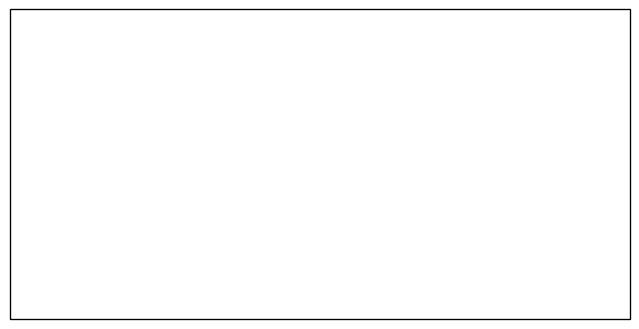

In [8]:
largura=800
altura=800
dpi=96
resolution='110m'
fig = plt.figure(figsize = (largura/dpi, altura/dpi), dpi=dpi)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

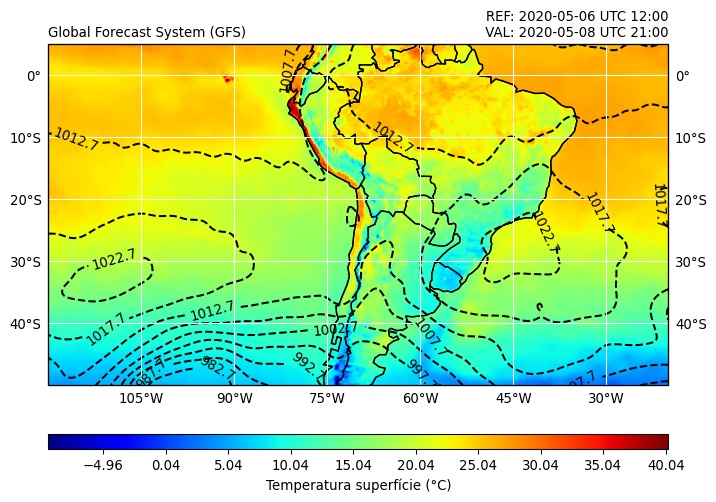

In [16]:
largura=800 
altura=800 
dpi=96 
resolution='110m' 
color = 'black' 
linewidth = 1 

fig = plt.figure(figsize = (largura/dpi, altura/dpi), dpi=dpi) 

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) 

ax.coastlines(resolution=resolution, color=color, linewidth=linewidth) 

features = cf.NaturalEarthFeature('cultural', 'admin_0_countries', resolution, edgecolor = 'black', facecolor = 'none') 

ax.add_feature(features) 

from matplotlib.cm import get_cmap
lat = data_parse.lat
lon = data_parse.lon
clevel_slp = np.arange(pressure_sfc.min(),  pressure_sfc.max() , 5)
line_slp = ax.contour(lon, lat, pressure_sfc,
                         clevel_slp, colors='black', 
                              linestyles='dashed',
                            transform = ccrs.PlateCarree())
plt.clabel( line_slp, fmt = '%1.1f')
clevel_temp = np.arange(temperature_sfc.min(), 
                          temperature_sfc.max(), 0.2)
color_temp = ax.contourf(lon, lat, temperature_sfc, clevel_temp,
                             cmap=get_cmap('jet'),
                           transform=ccrs.PlateCarree())
cb = fig.colorbar(color_temp, orientation='horizontal', 
                          pad=0.08, aspect=40)
cb.set_label('Temperatura superfície (°C)')
time_ = data_parse.time
time = str(time_[0].values)[:16].split('T')
reftime = str(data_parse.reftime.values[0])[:16].split('T')
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),
                     color='white', linestyles='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = True
gl.xlabels_top = False
plt.title('Global Forecast System (GFS)',loc='left',fontsize=10)
plt.title('REF: {} UTC {}\n VAL: {} UTC {}'.format(reftime[0],reftime[1],time[0],time[1]),loc='right',fontsize=10)
plt.show()
